# Model 0.15 - Leave One Feature Out (LOFO)
- Better feature analysis using LOFO, however expect it to be time consuming
- Switch from KFold to StratifiedKFold
- Feature analysis with LOFO revealed little and if anything told us nothing needed changing
- Applied LOFO with reduced trees and less folds on every feature, which did not do well
- Applied LOFO on grouped features, which gave more consistent results but results do little to improve model
- LOFO can be removed 


In [272]:
import re
import itertools
import ml_metrics
import string
import nltk
import scipy
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from functools import lru_cache
from scipy.sparse import hstack
# from scipy.ndimage.filters import gaussian_filter1d as gaussian
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            precision_recall_curve, \
                            log_loss, \
                            roc_auc_score, \
                            roc_curve
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

In [2]:
# hides warnings - think it needs running after modules imported
import warnings
warnings.simplefilter("ignore")

In [3]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [4]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv", index_col="BreedID")
df_colors = pd.read_csv("../input/color_labels.csv")

In [5]:
colors = df_colors['ColorID']
breeds = df_breeds.index

## Functions

### Functions: Feature Engineering

In [6]:
def apply_word_flags(df, words, drop=True):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    return df.drop(columns=['Description'] if drop else [])

In [195]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [383]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'Colour_{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'Colour_{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [9]:
def create_breed_keywords(df):
    """Creates unique list of keywords from provided breeds dataframe"""
    breed_keywords = []
    for breed in df['BreedName']:
        breed = re.sub(r'[/(/)]', '', breed)  # remove braces
        keywords = breed.split()
        breed_keywords += keywords
    return set(breed_keywords)

In [10]:
def apply_breed_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                    
    return df

In [11]:
# check for specific language - defaults to english
def language_flag(text, language='english'):
    tokens = wordpunct_tokenize(text)
    words = set([word.lower() for word in tokens])
    keywords = set(stopwords.words(language))
    common_words = words & keywords
    return len(common_words) > 0

In [12]:
def website_flag(text):
    keywords = ['www.', '.org', '.my', '.com']
    match = map(lambda x: text.find(x) >= 0, keywords)
    return sum(match) > 0

### Functions: Scoring 

In [13]:
# Kappa weighted prediction, also taking into account natural distribution of training truth values
@lru_cache(maxsize=128)
def quad_weights(i, n=5):
    return 1-(i**2 / (n-1)**2)

def weighted_prediction(proba, defaults):
    prediction = []
    for row in proba:
        row = [p-defaults[i] if p-defaults[i] > 0 else 0 for i,p in enumerate(row)]
        k_lst = []
        for i in range(len(row)):
            k_score = sum([p * quad_weights(abs(i-j)) for j, p in enumerate(row)])
            k_lst.append(k_score)
        prediction.append(np.argmax(k_lst))
    return prediction           

### Functions: Analyse Model 

In [196]:
# function from sklearn website example code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Preparing data

In [485]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()
df_combined['Description'] = df_combined['Description'].fillna('')
description = df_combined['Description']

# Rescuer
rescue_map = Counter(df_combined['RescuerID'])
rescuer_counts = df_combined['RescuerID'].map(rescue_map)

# Breeds
all_test_breeds = df_test['Breed1'].append(df_test['Breed2'])
df_test_breeds = df_breeds.loc[all_test_breeds[all_test_breeds > 0].unique(), :]
breed_keywords = create_breed_keywords(df_test_breeds)

# Prepare data for modelling 
df_combined['english'] = description.apply(language_flag)
df_combined['website'] = description.apply(website_flag)
df_combined['rescuer_counts'] = rescuer_counts
df_combined['desc_length'] = df_combined['Description'].apply(len)
df_combined['desc_word_count'] = df_combined['Description'].apply(lambda x: len(x.split()))

df_combined = apply_word_flags(df_combined, keywords, drop=False)
df_combined = apply_color_flags(df_combined, colors)
df_combined = apply_breed_flags(df_combined, breed_keywords, df_breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'AdoptionSpeed', 'RescuerID', 'Breed1', 'Breed2', 'Sterilized'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

In [486]:
# remove description feature
X_train_all = X_train_all.drop(columns=['Description'])
X_test_all  = X_test_all.drop(columns=['Description'])

## Test XGBoost model

In [376]:
params = {'max_depth': 4, 
          'learning_rate': 0.2, 
          'n_estimators': 200, 
          'silent': True, 
          'objective': 'multi:softprob', 
          'booster': 'gbtree',
          'tree_method': 'hist',
          'n_jobs': 3,
          'gamma': 0, 
          'min_child_weight': 1, 
          'max_delta_step': 0, 
          'subsample': 0.8, 
          'colsample_bytree': 1, 
          'colsample_bylevel': 1, 
          'reg_alpha': 0, 
          'reg_lambda': 1, 
          'scale_pos_weight': 1, 
          'base_score': 0.2, 
          'random_state': rnd, 
          'missing': None,
          'verbose': 0,
          'verbosity': 3,}

In [377]:
def cv_testing(X, y, params, folds=5, dataframe=True):

    scores = defaultdict(list)

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rnd)
    folds = skf.split(X, y)

    for i, (train_indx, test_indx) in enumerate(folds, 1):
        
        print(f"Fold {i}")
        
        # flag dataframe determines whether to use iloc or "normal" masking for (sparse) arrays
        if not dataframe:
            X_train, X_test = X[train_indx], X[test_indx]
            y_train, y_test = y[train_indx], y[test_indx]
        else:
            X_train, X_test = X.iloc[train_indx], X.iloc[test_indx]
            y_train, y_test = y.iloc[train_indx], y.iloc[test_indx]

            
        clf = xgb.XGBClassifier(**params)

        clf.fit(X_train, y_train)

#         prediction = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        # alternative kappa weighted consideration
        total_count = y_train.shape[0]
        defaults = {k:v/total_count for k,v in Counter(y_train).items()}
        prediction = weighted_prediction(proba, defaults)
        

        scores['kappa'].append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
        scores['accuracy'].append(accuracy_score(y_test, prediction))
        scores['confusion'].append(confusion_matrix(y_test, prediction))
        scores['precision'].append(precision_score(y_test, prediction, average=None))        
    
    print()
    
    return scores

In [487]:
scores = cv_testing(X=X_train_all, y=y_train_all, folds=10, params=params, dataframe=True)

Fold 1
[22:22:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[22:23:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[22:23:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[22:23:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 5
[22:23:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[22:23:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[22:23:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 8
[22:23:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[22:24:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[22:24:14] Tree method is selected to be 'hist'

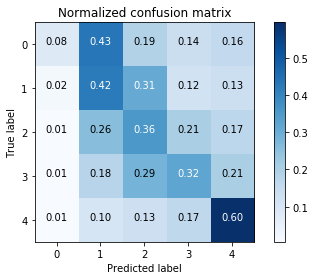

In [488]:
# plot normalised (by row) confusion matrix
cm = sum(scores['confusion'])  # sums element-wise
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

<BarContainer object of 5 artists>

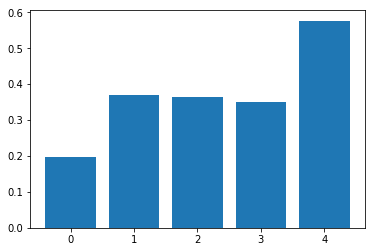

In [489]:
# plot average precision for each class
plt.bar([0,1,2,3,4], sum(scores['precision']) / len(scores['precision']))

In [490]:
# 0.415 --> 0.411 (Converted KFold to StratifiedKFold)
print("kappa:    {:.3}".format(np.mean(scores['kappa'])))
print("accuracy: {:.3}".format(np.mean(scores['accuracy'])))

kappa:    0.411
accuracy: 0.422


### LOFO Analysis

In [66]:
# get current features
features = X_train_all.columns
features.shape

(218,)

In [98]:
# convert features to set for easy comparison
features_set = set(features)

In [116]:
# user itertools combinations to iterate through all combinations
feature_combo = itertools.combinations(features, 217)

In [150]:
# reduce number of trees down to 50, to increase speed of model 
params['n_estimators'] = 50

In [161]:
# create dicationary to store scores
lofo_scores = {}

# create a baseline score, removing none of the features
model_score = cv_testing(X_train_all, y_train_all, folds=3, params=params)
lofo_scores['baseline'] = model_score

# iterate through combinations of features, removing one at a time
feature_combo = itertools.combinations(features, len(features)-1)
for i,combo in enumerate(feature_combo,1):
#     if i > 3: break
    combo_set = set(combo)
    difference = combo_set ^ features_set
    ignored_feature = difference.pop()
    print(f"{ignored_feature} ({i}/{len(features)})")
    X_lofo = X_train_all.drop(columns=[ignored_feature])
    model_score = cv_testing(X_lofo, y_train_all, folds=3, params=params)
    lofo_scores[ignored_feature] = model_score

Fold 1
[21:30:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:30:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:30:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

State_41415 (1/218)
Fold 1
[21:30:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:30:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:30:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

State_41401 (2/218)
Fold 1
[21:30:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:30:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:30:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

State_41367 

Fold 3
[21:33:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Gender_2 (25/218)
Fold 1
[21:33:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:33:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:33:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Gender_1 (26/218)
Fold 1
[21:33:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:33:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:33:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Staffordshire (27/218)
Fold 1
[21:33:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:33:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_hist

Fold 2
[21:36:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:36:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Charles (50/218)
Fold 1
[21:36:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:36:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:36:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Jack (51/218)
Fold 1
[21:36:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:36:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:36:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Ragamuffin (52/218)
Fold 1
[21:36:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
F


Fila (74/218)
Fold 1
[21:39:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:39:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:39:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Poodle (75/218)
Fold 1
[21:39:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:39:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:39:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Oriental (76/218)
Fold 1
[21:39:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:39:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:39:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Wes

Fold 3
[21:41:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Italian (99/218)
Fold 1
[21:42:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:42:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:42:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Bulldog (100/218)
Fold 1
[21:42:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:42:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:42:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Coon (101/218)
Fold 1
[21:42:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:42:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fo

Fold 2
[21:44:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:44:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Dalmatian (124/218)
Fold 1
[21:45:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:45:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:45:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Curl (125/218)
Fold 1
[21:45:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:45:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:45:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Russian (126/218)
Fold 1
[21:45:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


Mountain (148/218)
Fold 1
[21:47:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:47:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:48:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

American (149/218)
Fold 1
[21:48:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:48:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:48:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Shorthaired (150/218)
Fold 1
[21:48:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:48:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:48:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_his

Fold 3
[21:50:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Foo (173/218)
Fold 1
[21:50:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:51:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:51:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Birman (174/218)
Fold 1
[21:51:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:51:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:51:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Cairn (175/218)
Fold 1
[21:51:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:51:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 

Fold 3
[21:53:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

playful (198/218)
Fold 1
[21:53:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:54:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:54:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

looking (199/218)
Fold 1
[21:54:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:54:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:54:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

give (200/218)
Fold 1
[21:54:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:54:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
F

In [152]:
# for k,v in lofo_scores.items():
#     print(f"{k}: \t {np.mean(v['kappa'])} \t {np.mean(v['accuracy'])} ")

baseline: 	 0.38507533731892823 	 0.4071234207032582 
State_41415: 	 0.38507533731892823 	 0.4071234207032582 
State_41401: 	 0.38255707952804113 	 0.4081233670816153 
State_41367: 	 0.3858615740063054 	 0.40732346071125985 


In [310]:
# take maximum of each score and subtract baseline
lofo_importances = []
feature_labels = []
baseline = np.max(lofo_scores['baseline']['kappa'])
for k,v in lofo_scores.items():
    if k == 'baseline': 
        continue
    lofo_kappa = np.max(v['kappa'])
    kappa_diff = -1 * (lofo_kappa - baseline)
    feature_labels.append(k)
    lofo_importances.append(kappa_diff)
    

In [311]:
# create dataframe of importances
feature_importances = pd.DataFrame(lofo_importances,
                                   index = feature_labels,
                                   columns=['importance']).sort_values('importance', ascending=False)

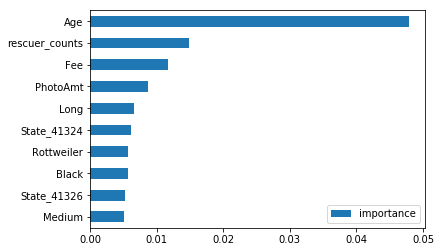

In [312]:
# most important
feature_importances.iloc[:10,:][::-1].plot.barh()

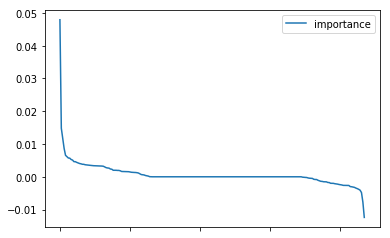

In [313]:
# overview
feature_importances.plot()

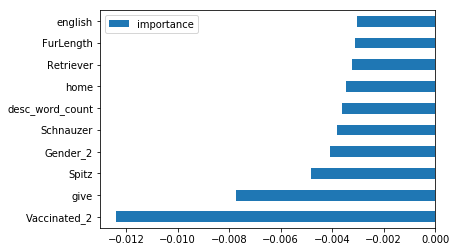

In [314]:
# least important
feature_importances.iloc[-10:,:][::-1].plot.barh()

In [315]:
# negative importance
feature_importances[feature_importances['importance'] < 0].sum()

importance   -0.103235
dtype: float64

In [316]:
# features which could be removed (verified not true)
remove_features = feature_importances[feature_importances['importance'] < 0].index
remove_features

Index(['Pekingese', 'Burmese', 'contact', 'Oriental', 'Pinscher',
       'Sterilized_2', 'Pit', 'State_41336', 'Calico', 'Australian', 'Maltese',
       'Shepherd', 'Bengal', 'Van', 'Chihuahua', 'Dachshund', 'Border',
       'State_41327', 'loving', 'Vaccinated_3', 'looking', 'rescued',
       'State_41342', 'playful', 'Siberian', 'State_41330', 'British',
       'Belgian', 'State_41325', 'German', 'Husky', 'Health', 'Tuxedo', 'C7',
       'Dewormed_1', 'english', 'FurLength', 'Retriever', 'home',
       'desc_word_count', 'Schnauzer', 'Gender_2', 'Spitz', 'give',
       'Vaccinated_2'],
      dtype='object')

### LOFO with grouped features
Takes into account one-hot encoding etc, and runs with larger number of trees and 10 fold.

In [382]:
# list of all features
existing = X_train_all.columns
for f in existing:
    print(f, end=', ')

Type, Age, MaturitySize, FurLength, Health, Quantity, Fee, VideoAmt, PhotoAmt, english, website, rescuer_counts, desc_length, desc_word_count, home, good, adopt, loving, give, looking, playful, rescued, cat, contact, C1, C2, C3, C4, C5, C6, C7, Shar, Akita, Tibetan, Highland, Long, Pug, Greyhound, Afghan, Ocicat, Husky, Russell, Irish, Cairn, Birman, Foo, Labrador, Laekenois, Rhodesian, Lakeland, Bengal, Bernard, Parson, Heeler, Inu, Saint, Hair, Devon, Fell, British, White, Terrier, Somali, Havanese, Sheltie, Forest, Dog, Dane, Shorthaired, American, Mountain, Spitz, Domestic, Exotic, Great, Boxer, Cymric, Tonkinese, Belgian, Turkish, Snowshoe, French, Pinscher, Whippet, DogBlue, Medium, Old, Angora, Retriever, Burmilla, English, Miniature, Russian, Curl, Dalmatian, Tiger, Chinchilla, Chausie, Eskimo, Cattle, Sheep, Munchkin, Corgi, Alaskan, Border, Breed, Himalayan, Blue, Malamute, Mixed, Maine, Golden, Chinese, Chow, Siberian, Patterdale, Bull, Coon, Bulldog, Italian, Van, Standard,

In [437]:
# all current features
features = X_train_all.columns

In [438]:
initial_features = [
    'Type',
    'Age',
    'MaturitySize',
    'FurLength',
    'Health',
    'Quantity',
    'Fee',
    'VideoAmt',
    'PhotoAmt',  
]

extra_features = [
    'english',
    'website',
    'rescuer_counts',
    'desc_length',
    'desc_word_count',
]

top_words = ['home', 'good', 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact',]
    
one_hot_features = ['Colour', 'Sterilized', 'Dewormed', 'Gender', 'Vaccinated', 'State',]

In [439]:
# create features groups dictionary to store feature masks and labels
feature_groups = {}

In [440]:
# initial features
for f in initial_features:
    feature_groups[f] = [False if e==f else True for e in features]
    features = [e if e!=f else '' for e in features]

In [441]:
# extra features
for f in extra_features:
    feature_groups[f] = [False if e==f else True for e in features]
    features = [e if e!=f else '' for e in features]

In [442]:
# top words
feature_groups['top_words'] = [False if e in top_words else True for e in features]
features = [e if e not in top_words else '' for e in features]

In [443]:
# one hot features
for f in one_hot_features:
    feature_groups[f] = [False if e.startswith(f) else True for e in features]
    features = [e if not e.startswith(f) else '' for e in features]

In [444]:
# Breeds
feature_groups['breeds'] = [False if e != '' else True for e in features]
features = [e if e != '' else '' for e in features]


In [452]:
# testing mask
features = X_train_all.columns
for f in features[feature_groups['Colour']]:
    print(f, end=", ")

Type, Age, MaturitySize, FurLength, Health, Quantity, Fee, VideoAmt, PhotoAmt, english, website, rescuer_counts, desc_length, desc_word_count, home, good, adopt, loving, give, looking, playful, rescued, cat, contact, Shar, Akita, Tibetan, Highland, Long, Pug, Greyhound, Afghan, Ocicat, Husky, Russell, Irish, Cairn, Birman, Foo, Labrador, Laekenois, Rhodesian, Lakeland, Bengal, Bernard, Parson, Heeler, Inu, Saint, Hair, Devon, Fell, British, White, Terrier, Somali, Havanese, Sheltie, Forest, Dog, Dane, Shorthaired, American, Mountain, Spitz, Domestic, Exotic, Great, Boxer, Cymric, Tonkinese, Belgian, Turkish, Snowshoe, French, Pinscher, Whippet, DogBlue, Medium, Old, Angora, Retriever, Burmilla, English, Miniature, Russian, Curl, Dalmatian, Tiger, Chinchilla, Chausie, Eskimo, Cattle, Sheep, Munchkin, Corgi, Alaskan, Border, Breed, Himalayan, Blue, Malamute, Mixed, Maine, Golden, Chinese, Chow, Siberian, Patterdale, Bull, Coon, Bulldog, Italian, Van, Standard, Australian, Hound, Cavalier

In [466]:
# set parameter back to 200 trees
params['n_estimators'] = 200

In [467]:
# create dicationary to store scores
lofo_scores = {}

# create a baseline score, removing none of the features
model_score = cv_testing(X_train_all, y_train_all, folds=10, params=params)
lofo_scores['baseline'] = model_score

# iterate through combinations of features
for i,(feature, mask) in enumerate(feature_groups.items(), 1):
#     if i > 3: break
    target = list(features[mask])
    print(f"{feature} ({i}/{len(feature_groups.keys())})")
    X_lofo = X_train_all[target]
    model_score = cv_testing(X_lofo, y_train_all, folds=10, params=params)
    lofo_scores[feature] = model_score

Fold 1
[21:40:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:41:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:41:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[21:41:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 5
[21:41:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[21:41:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[21:41:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 8
[21:42:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[21:42:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[21:42:25] Tree method is selected to be 'hist'

Fold 8
[21:52:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[21:52:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[21:52:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

VideoAmt (8/22)
Fold 1
[21:52:47] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[21:52:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[21:53:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[21:53:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 5
[21:53:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[21:53:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[21:53:39] Tree method is sele

Fold 5
[22:04:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 6
[22:04:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 7
[22:04:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 8
[22:04:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 9
[22:05:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 10
[22:05:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.

Colour (16/22)
Fold 1
[22:05:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 2
[22:05:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 3
[22:05:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Fold 4
[22:05:43] Tree method is selec

In [480]:
# take maximum of each score and subtract baseline
lofo_importances = []
feature_labels = []
baseline = np.mean(lofo_scores['baseline']['kappa'])
for k,v in lofo_scores.items():
    if k == 'baseline': 
        continue
    lofo_kappa = np.mean(v['kappa'])
    kappa_diff = -1 * (lofo_kappa - baseline)
    feature_labels.append(k)
    lofo_importances.append(kappa_diff)
    

In [481]:
# create dataframe of importances
feature_importances = pd.DataFrame(lofo_importances,
                                   index = feature_labels,
                                   columns=['importance']).sort_values('importance', ascending=False)

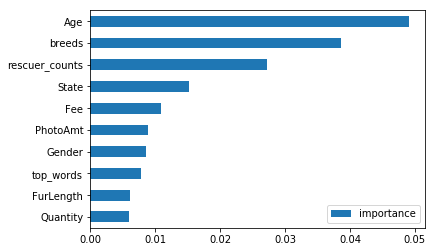

In [482]:
# most important
feature_importances.iloc[:10,:][::-1].plot.barh()

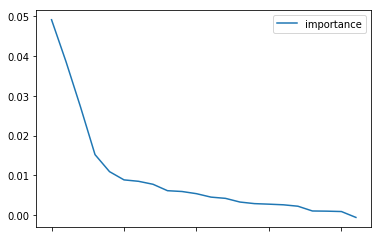

In [483]:
# overview
feature_importances.plot()

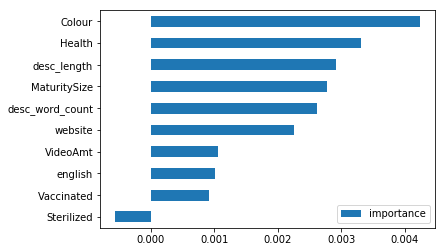

In [484]:
# least important
feature_importances.iloc[-10:,:][::-1].plot.barh()

In [492]:
# negative importance
feature_importances[feature_importances['importance'] < 0].sum()

importance   -0.000553
dtype: float64

# Run model on test data

In [495]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = weighted_prediction(proba, defaults)

[22:10:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


# Model Analysis

### Feature Importance

In [496]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_all.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

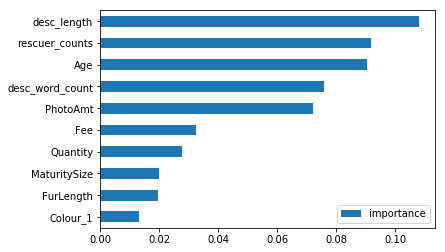

In [497]:
# top 10 features
feature_importances.iloc[:10,:][::-1].plot.barh()

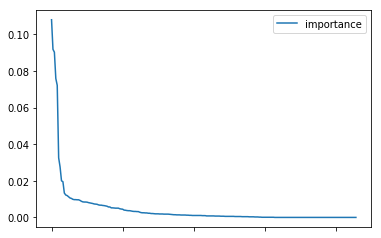

In [498]:
# distribution of feature importance
feature_importances.plot()

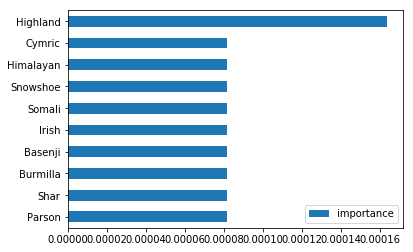

In [499]:
# bottom 10 least important features
feature_importances[feature_importances['importance'] > 0].iloc[-10:,:][::-1].plot.barh()

In [500]:
# count of non-importance features
not_important = feature_importances[feature_importances['importance'] == 0]
len(not_important)

58

In [501]:
not_important.index

Index(['Brasileiro', 'Rex', 'Pei', 'Shih', 'Westie', 'Shiba', 'Shetland',
       'Mau', 'Jack', 'Charles', 'Blue', 'Ragamuffin', 'Heeler', 'Whippet',
       'Great', 'Mountain', 'Shorthaired', 'Sheltie', 'Havanese', 'Fell',
       'Devon', 'Saint', 'Bernard', 'Old', 'Lakeland', 'Laekenois', 'Foo',
       'Cairn', 'Ocicat', 'Afghan', 'Greyhound', 'Tibetan', 'Akita', 'DogBlue',
       'Chinchilla', 'Ridgeback', 'Italian', 'Norwegian', 'King', 'Applehead',
       'Fila', 'West', 'Pixie-Bob', 'Pyrenees', 'Cavalier', 'Standard', 'Coon',
       'Chausie', 'Patterdale', 'Chinese', 'Mixed', 'Malamute', 'Alaskan',
       'Munchkin', 'Sheep', 'Cattle', 'Eskimo', 'State_41415'],
      dtype='object')

In [30]:
# X_train_all = X_train_all.drop(columns=list(not_important.index))
# X_test_all = X_test_all.drop(columns=list(not_important.index))

# Final run on test model and submission

In [31]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
proba = clf.predict_proba(X_test_all)
total_count = y_train_all.shape[0]
defaults = {k:v/total_count for k,v in Counter(y_train_all).items()}
prediction = np.array(weighted_prediction(proba, defaults))

[16:23:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [32]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])